In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import argparse
import os
import tensorflow as tf
sns.set_style('whitegrid')

from glob import glob
# test GPU


Using TensorFlow backend.


In [2]:
"""
We have two datasets, NIH and our own COVID-19.
NIH dataset contains more than 100,000 images of different thoracic disease.

During data preprocessing, we could preocess the two datasets seperately
"""
## Preprocess NIH dataset
# read NIH data, the csv

df_NIH = pd.read_csv(r'C:\Users\Zijian\OneDrive - Cranfield University\Group project\NIH\Data_Entry_2017.csv')
# only keep the illnesss label and image names

df_NIH = df_NIH[['Image Index', 'Finding Labels']]
# create a column to store the full path of images for later reading
# You should change the below path when running at your computer

my_glob = glob('C:/Users/Zijian/OneDrive - Cranfield University/Group project/NIH/images/images/*.png')
print('Number of Observations: ', len(my_glob))
full_img_paths = {os.path.basename(x): x for x in my_glob}

df_NIH['path'] = df_NIH['Image Index'].map(full_img_paths.get)
# create new columns for each illness
# total 14 thoracic disease： pathology_list = ['Cardiomegaly','Emphysema','Effusion','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia', 'No Finding'] #'Hernia',
# We only keep eight disease
# pathology_list = ['Cardiomegaly', 'Effusion', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Mass', 'Infiltration', 'Pneumonia', 'No Finding']

df_NIH_effusion = df_NIH[df_NIH['Finding Labels'].isin(['Effusion'])]
df_NIH_atelectasis = df_NIH[df_NIH['Finding Labels'].isin(['Atelectasis'])]
df_NIH_infiltration = df_NIH[df_NIH['Finding Labels'].isin(['Infiltration'])]
df_NIH_pneumonia = df_NIH[df_NIH['Finding Labels'].isin(['Pneumonia'])]
df_NIH_none = df_NIH[df_NIH['Finding Labels'].isin(['No Finding'])]
print('effusion :', len(df_NIH_effusion))
print('atelectasis :', len(df_NIH_atelectasis))
print('infiltration :', len(df_NIH_infiltration))
print('pneumonia :', len(df_NIH_pneumonia))
print('health :', len(df_NIH_none))

df_NIH_none = df_NIH_none.sample(n=10000)
# concat the five dataframe together

xray_data = pd.concat([df_NIH_effusion, df_NIH_atelectasis, 
	df_NIH_infiltration, df_NIH_pneumonia, df_NIH_none])
# split data

train_set, test_set = train_test_split(xray_data, test_size = 0.2, random_state = 1993)
# quick check to see that the training and test set were split properly

print('training set: ', len(train_set))
print('test set: ', len(test_set))

print('full data set: ', len(xray_data))
# Create ImageDataGenerator, to perform significant image augmentation
# Utilizing most of the parameter options to make the image data even more robust

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
image_size = (128, 128) # image re-sizing target

train_generator = train_datagen.flow_from_dataframe(
	dataframe=train_set,
	directory=None,
	x_col='path', 
	y_col = 'Finding Labels',
	target_size=image_size,
	color_mode='rgb',
	batch_size=32,
	class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
	dataframe=test_set,
	directory=None,
	x_col='path', 
	y_col = 'Finding Labels',
	target_size=image_size,
	color_mode='rgb',
	batch_size=32,
	class_mode='categorical'	
)

test_X, test_Y = next(test_datagen.flow_from_dataframe(
	dataframe=test_set,
	directory=None,
	x_col='path', 
	y_col = 'Finding Labels',
	target_size=image_size,
	color_mode='rgb',
	batch_size= 5000,
	class_mode='categorical'
	))
# load the VGG16 network, ensuring the head FC layer sets are left off

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))
# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(5, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
	layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print("[INFO] training head...")
EPOCHS = 20

H = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=20)
# make predictions on the testing set

print("[INFO] evaluating network...")

predIdxs = model.predict(test_X)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(test_Y.argmax(axis=1), predIdxs))
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity

cm = confusion_matrix(test_Y.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity

print(cm)
print("acc: {:.6f}".format(acc))
print("sensitivity: {:.6f}".format(sensitivity))
print("specificity: {:.6f}".format(specificity))


Number of Observations:  112120
effusion : 3955
atelectasis : 4215
infiltration : 9547
pneumonia : 322
health : 60361
training set:  22431
test set:  5608
full data set:  28039
Found 22431 validated image filenames belonging to 5 classes.
Found 5608 validated image filenames belonging to 5 classes.
Found 5608 validated image filenames belonging to 5 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
____________________________

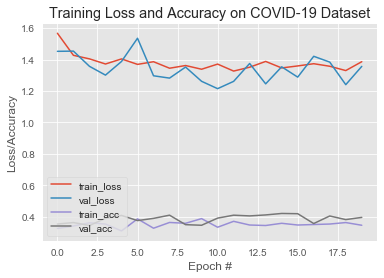

In [3]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
